<a href="https://colab.research.google.com/github/matthewchung74/dog-pooping-detectron/blob/main/Dog_Pooping_Dectron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The **Dog Pooping in my yard Transformer Detectron** tutorial using Pytorch and Transformers!

The problem is some owners do not pick up their dog poop. I believe this is not a problem isolated to where I live, in the bay area, but is ubiquitious to the world. To combat this problem, I am working on the **Dog Pooping in my yard Transformer Detectron**.  

We're going to start with getting something working using transformers, then in parts 2 and 3, we'll understand the details of what we're doing.

This work is based on this project
* https://github.com/rwightman/pytorch-image-models
* http://peterbloem.nl/blog/transformers


### The Data
Two folders, one called pooping, one called not-pooping. There are 19 pooping images and 17 not-pooping. Now you may be wondering, how can we train off 19 images? The answer is below, hint, look for `pretraining` in the TIMM section. 

Let's take a look at the data. We're going to do some standard pytorch stuff here.

In [1]:
!wget https://github.com/matthewchung74/dog-pooping-detectron/raw/main/data.zip
!unzip -qq -n data.zip -d data

--2021-01-22 16:30:51--  https://github.com/matthewchung74/dog-pooping-detectron/raw/main/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthewchung74/dog-pooping-detectron/main/data.zip [following]
--2021-01-22 16:30:51--  https://raw.githubusercontent.com/matthewchung74/dog-pooping-detectron/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333201 (325K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 325.39K  --.-KB/s    in 0.06s   

2021-01-22 16:30:51 (4.99 MB/s) - ‘data.zip’ saved [333201/333201]



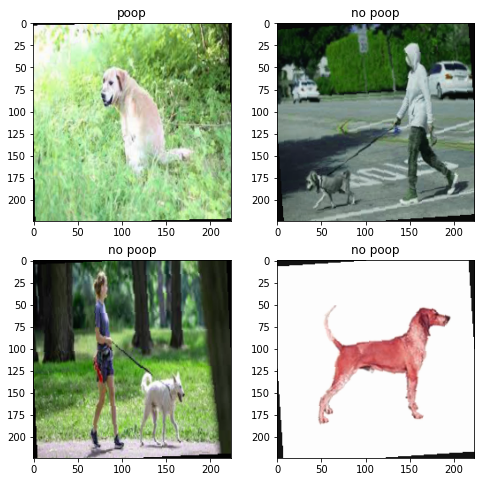

In [2]:
import glob
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

data_dir = "./data"
all_files = glob.glob(os.path.join(data_dir,'**/*.jpg'))
labels = [int('no-poop' not in label) for label in all_files] 

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

class PoopDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = self.labels[idx]
        return img_transformed, label

all_files_len = len(all_files)
train_dataset = PoopDataset(all_files[:all_files_len-4], labels[:all_files_len-4], transform=train_transforms)
train_loader = DataLoader(dataset = train_dataset, batch_size=4, shuffle=True )

valid_dataset = PoopDataset(all_files[all_files_len-4:], labels[all_files_len-4:], transform=test_transforms)
valid_loader = DataLoader(dataset = train_dataset, batch_size=4, shuffle=True )

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
images, labels = next(iter(train_loader)) 

for idx, ax in enumerate(axes.ravel()):
    img = transforms.ToPILImage()(images[idx])
    title = "poop" if labels[idx] == 1 else "no poop"
    ax.set_title(title)
    ax.imshow(img)

### Aren't Transformers for NLP?
Nope. This paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) changed all that. We will get more into the details in future parts. This tutorial is all about quickly being able to detect pooping dogs which you can take and apply to your own problem, such as cats pooping in your yard! 

First let's set our device to use the gpu

In [3]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### What is TIMM
[Timm](https://github.com/rwightman/pytorch-image-models) is the open source library we're goign to use to get up and running. If you have time, check out his repo. It is amazing. In a nutshell, it is a library of SOTA architectures with pre-trained weights.

1.   First, let's `pip` install it.
2.   Then let's look at all the models `list_models` that have pretraining, and match the wildcard `vit` which stands for visual transformer. We will pick the one we're interested in, `vit_base_patch16_224`
3.   Let's print out a summary.


In [4]:
!pip install timm

     |████████████████████████████████| 245kB 3.6MB/s 


In [5]:
import timm
from pprint import pprint
model_names = timm.list_models('*vit*', pretrained=True)
pprint(model_names)

['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224']


In [6]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = model.to(device)
model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

Now this summary above is large, and we'll cover what it all means later. What is important now is the last time `(head)`. This is the last layer which classifies to 1000 different classes. We only have 2, is it a pooping dog or not. So let's change that.

In [7]:
import torch.nn as nn
model.head = nn.Linear(768, 2).to(device)

## Standard training stuff
Let's do some standard pytorch training stuff. 

*   I'm going to set the batchsize to `35` since there are only 35 training samples
*   we're going to do 20 epochs which is arbitrary
*   we're going to guess at a reasonable learning rate and gamma.

In [8]:
epochs = 4
lr = 3e-5
gamma = 0.7

Now we're going to setup our `criterion`, `optimizer`, `scheduler` like any other pytorch project.


In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

And now we're going to train much like any other pytorch training loop.

In [10]:
from tqdm.notebook import tqdm
import pdb

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(dtype=torch.long, device=device)
        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(dtype=torch.long, device=device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 0.6896 - acc: 0.5938 - val_loss : 0.3273 - val_acc: 0.8750




Epoch : 2 - loss : 0.3012 - acc: 0.9375 - val_loss : 0.1665 - val_acc: 1.0000




Epoch : 3 - loss : 0.1332 - acc: 1.0000 - val_loss : 0.0797 - val_acc: 1.0000




Epoch : 4 - loss : 0.0645 - acc: 1.0000 - val_loss : 0.0413 - val_acc: 1.0000

